# Keras Model CNN for Classification
## April 8, 2018

In [77]:
import tensorflow
import keras
import gensim

import numpy as np
from numpy import array
import pandas as pd
import re

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences

from keras.layers import Conv1D, MaxPooling1D , Dense, Dropout, Activation, LSTM
from keras.layers.embeddings import Embedding
from keras.layers.core import Flatten
from keras.models import Sequential
from keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint

from keras.utils import to_categorical

# NLTK libs
from nltk.tokenize import TweetTokenizer

%matplotlib inline

## Data Preprocessing

In [2]:
data = pd.read_csv('../../../Comments_FanofGame_data_bandwagon.csv')

In [3]:
data.head()

,Unnamed: 0,author_flair,submission_title,comment_body,fan_of_team_playing,bandwagon,fan_of_team_playing_w_bandwagon
0,0,Bengals,Game Thread: Detroit Lions (8-6) at Cincinnati...,I love Lions fans cause we can drink bleach to...,1,0,1
1,1,Lions,Game Thread: Detroit Lions (8-6) at Cincinnati...,"I was back and forth with this, but I'm on the...",1,0,1
2,2,Lions,Game Thread: Detroit Lions (8-6) at Cincinnati...,Ebron with that sick Naruto run.,1,0,1
3,3,Lions,Game Thread: Detroit Lions (8-6) at Cincinnati...,"""Here, Merry Christmas. have this win.""\n\n""No...",1,0,1
4,4,Eagles - Bandwagon,Game Thread: Detroit Lions (8-6) at Cincinnati...,The coaching staff does realize that if we los...,0,1,0


In [4]:
# Remove problematic comments
data = data[data.comment_body.notnull()]
data = data[data.comment_body != "no value"]
data = data[data.comment_body!='[removed]']
data = data[data.comment_body!='[deleted]']
data = data[~data.comment_body.str.contains("\^This \^message \^was \^created \^by \^a \^bot")]
data = data[~data.comment_body.str.contains("\*\*Please review the rules for")]
data = data[data.notnull()]


# Remove Superbowl and playoff Threads
data = data[
(data.submission_title!='Super Bowl LII Game Thread: Philadelphia Eagles (15-3) at New England Patriots (15-3)') &
(data.submission_title!='Super Bowl LII Game Thread: Philadelphia Eagles (15-3) at New England Patriots (15-3) (Second Half)') &
(data.submission_title!='Super Bowl 51 Pre Game Thread: New England Patriots (14-2) at Atlanta Falcons (11-5)') &
(data.submission_title!='Super Bowl 51 Post Game Thread: New England Patriots (14-2) at Atlanta Falcons (11-5)') &
(data.submission_title!='Game Thread: Atlanta Falcons (10-6) at Los Angeles Rams (11-5)') &
(data.submission_title!='Game Thread: Tennessee Titans (9-7) at Kansas City Chiefs (10-6)') &
(data.submission_title!='Game Thread: Buffalo Bills (9-7) at Jacksonville Jaguars (10-6)') &
(data.submission_title!='Game Thread: Carolina Panthers (11-5) at New Orleans Saints (11-5)') &
(data.submission_title!='Game Thread: Atlanta Falcons (11-6) at Philadelphia Eagles (13-3)') &
(data.submission_title!='Game Thread: Tennessee Titans (10-7) at New England Patriots (13-3)') &
(data.submission_title!='Game Thread: Jacksonville Jaguars (11-6) at Pittsburgh Steelers (13-3)') &
(data.submission_title!='Game Thread: Jacksonville Jaguars (12-6) at New England Patriots (14-3)') &
(data.submission_title!='Game Thread: Minnesota Vikings (14-3) at Philadelphia Eagles (14-3)') 
]

data['fan_binary'] = data.fan_of_team_playing.astype(int)

data.count()

Unnamed: 0                         1542039
author_flair                       1542039
submission_title                   1542039
comment_body                       1542039
fan_of_team_playing                1542039
bandwagon                          1542039
fan_of_team_playing_w_bandwagon    1542039
fan_binary                         1542039
dtype: int64

In [127]:
# Borrowed some functions from the w266 utils.py file
# Miscellaneous helpers
def flatten(list_of_lists):
    """Flatten a list-of-lists into a single list."""
    return list(itertools.chain.from_iterable(list_of_lists))


# Word processing functions
def canonicalize_digits(word):
    if any([c.isalpha() for c in word]): return word
    word = re.sub("\d", "DG", word)
    if word.startswith("DG"):
        word = word.replace(",", "") # remove thousands separator
    return word

def canonicalize_word(word, wordset=None, digits=True):
    #replace hyperlinks with one instance of "postedhyperlinkvalue"
    word = re.sub(r"(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w\.-]*)*\/?\S*", "postedhyperlinkvalue", word)
    word = re.sub(r"(postedhyperlinkvalue)+", "postedhyperlinkvalue", word)
    #only lower case words (2 letters or longer) that are not all upper case
    if not word.isupper() or len(word) == 1:
        word = word.lower()
    #replace things like haha with ha
    word = re.sub(r"([a-z]{2,})\1{2,}", r"\1", word)
    #replace any three consecutive, identical letters with two instances of that letter
    word = re.sub(r"([a-z])\1{2,}", r"\1\1", word)
    #replace any two consecutive, identical consonants at the beginning of a string with one of that consonant
    word = re.sub(r"(^[^aeiou])\1{1,}", r"\1", word)
    
    #replace digits with a stand-in token
    if digits:
        if (wordset != None) and (word in wordset): return word
        word = canonicalize_digits(word) # try to canonicalize numbers
    if (wordset == None) or (word in wordset):
        return word
    else:
        return constants.UNK_TOKEN

def canonicalize_words(words, **kw):
    return [canonicalize_word(word, **kw) for word in words]

from nltk.stem import PorterStemmer
    
def stem_sentence(token_sent, stemmer=PorterStemmer()):
    stem_token_sent = []
    for word in token_sent:
        stem_token_sent.append(stemmer.stem(word))
    return stem_token_sent   

In [123]:
def make_data(data, target, tokenizer=TweetTokenizer(), canonize=True, stem=True):
        
    # Separate comments
    comments = data.loc[:, 'comment_body']
    labels = data.loc[:, target]
    
    # Convert to list
    comment_list = comments.values.tolist()
    
    # Tokenize comments
    tokenizer = tokenizer
    # A list of lists of tokenized sentences: word == string/token; sentence == list of string/tokens
    tokenized_sentences = [tokenizer.tokenize(sentence) for sentence in comment_list]
    
    if stem:
        # Stem words
        comments_stem = []
        for sentence in tokenized_sentences:
            x_tokens_stem = stem_sentence(token_sent=sentence, stemmer=PorterStemmer())
            comments_stem.append(x_tokens_stem)
        tokenized_sentences = comments_stem
    
    if canonize:
        # Canonize words
        comments_canon = []
        for sentence in tokenized_sentences:
            x_tokens_canon = canonicalize_words(sentence)
            comments_canon.append(x_tokens_canon)
        # A list of lists of scrubbed tokens; token == word, list == sentence
        tokenized_sentences = comments_canon
    
    x_tokens = tokenized_sentences
        
    return comments, x_tokens, labels

In [128]:
comments, x_tokens, labels = make_data(data, target='fan_of_team_playing', canonize=True, stem=False)

In [102]:
comments[:3]

0    I love Lions fans cause we can drink bleach to...
1    I was back and forth with this, but I'm on the...
2                    Ebron with that sick Naruto run. 
Name: comment_body, dtype: object

In [132]:
x_tokens[1542030:]

[['i',
  'hope',
  'so',
  '.',
  'the',
  'kid',
  'has',
  'looked',
  'very',
  'sharp',
  ',',
  'better',
  'than',
  'fitztragic',
  '.'],
 ['it',
  'really',
  'was',
  '.',
  'one',
  'of',
  'those',
  'catches',
  'that',
  'just',
  'makes',
  'you',
  'say',
  '"',
  'how',
  'the',
  'hell',
  'did',
  'that',
  'even',
  'happen',
  '?',
  '!',
  '"'],
 ["there's",
  'lack',
  'of',
  'talent',
  'and',
  'bad',
  'scheme',
  '(',
  'defense',
  ')',
  'and',
  'then',
  "there's",
  'lack',
  'of',
  'polish',
  '(',
  'special',
  'teams',
  ')',
  '.',
  'i',
  'would',
  'point',
  'out',
  'that',
  'the',
  'defense',
  'has',
  'also',
  'had',
  'a',
  'lot',
  'of',
  'penalties',
  '.'],
 ["it's",
  'very',
  'clear',
  'watching',
  'them',
  ',',
  'so',
  'far',
  ',',
  'that',
  'our',
  'last',
  'two',
  'drafts',
  'have',
  'really',
  'transformed',
  'this',
  'team',
  '.',
  'we',
  'have',
  'a',
  'lot',
  'of',
  'very',
  'young',
  'talent',
  

In [19]:
labels[:3]

0    1
1    1
2    1
Name: fan_of_team_playing, dtype: int64

In [134]:
# Build word2vec embeddings model (skip-gram w/negative sampling)
vector_dim = 100
model_nsg_pp2 = gensim.models.Word2Vec(sentences=x_tokens, sg=1, size=vector_dim, hs=0, negative=12, workers=8, compute_loss=True, max_vocab_size=None, min_count=0)

In [135]:
# Save model
model_nsg_pp2.save('model_nsg_pp2.bin')

In [106]:
# You can easily load the model like this:
model_nsg_pp2 = gensim.models.Word2Vec.load('model_nsg_pp2.bin')

In [136]:
# Take a look at the embeddings
print(model_nsg_pp2)

Word2Vec(vocab=134884, size=100, alpha=0.025)


In [153]:
# Look at example word similarities WARNING: SOME INAPPROPRIATE WORDS MAY BE DISPLAYED
print(model_nsg_pp2.wv.most_similar(':(')) # it can handle emoticons
#print(model_nsg_pp.wv.most_similar('Bengals')) # ok, i expect the steelers but the browns...
print(model_nsg_pp2.wv.most_similar('lol')) # it can handle shorthand
print(model_nsg_pp2.wv.most_similar('touchdown')) # makes sense
print(model_nsg_pp2.wv.most_similar('fan')) # well, that's a mixed bag
print(model_nsg_pp.wv.most_similar('referee')) # actually identifies some refs by name
print(model_nsg_pp.wv.most_similar('fuck')) # actually identifies some refs by name

[(':/', 0.9012995958328247), (":'(", 0.8864564895629883), ('=(', 0.8806827068328857), (':-(', 0.8279445171356201), (';(', 0.8038519024848938), ('😣', 0.793906569480896), ('fml', 0.7796511054039001), (':)', 0.771406888961792), ('.', 0.7657585144042969), (':-/', 0.7642029523849487)]
[('lmao', 0.9632657170295715), ('lmfao', 0.9145869016647339), ('haha', 0.9018850326538086), ('lmaoo', 0.8737468719482422), ('rofl', 0.8569039106369019), ('loll', 0.8550130128860474), ('hahah', 0.8459514379501343), ('lolol', 0.8391028046607971), ('bahaha', 0.8385341167449951), ('lmfaoo', 0.8384135961532593)]
[('TD', 0.9414183497428894), ('td', 0.9301056861877441), ('tuddy', 0.8021426200866699), ('interception', 0.7971596121788025), ('turnover', 0.7834737300872803), ('fumble', 0.7796392440795898), ('touchdowns', 0.7755153179168701), ('freebie', 0.7647457122802734), ('strip-sack', 0.7621861696243286), ('INT', 0.7490881085395813)]
[('hater', 0.801754355430603), ('lifelong', 0.783571720123291), ('fans', 0.771250963

In [63]:
# get the word vector of "the"
print(model_nsg_pp2.wv['the'])

[-2.09258407e-01  4.57670689e-01  1.49294421e-01 -1.83503330e-01
  3.69378954e-01  9.88171324e-02 -1.82675496e-01 -2.47694314e-01
 -1.34315297e-01  3.04550409e-01  3.64713013e-01  2.84847736e-01
 -2.19126791e-01 -2.42191046e-01  1.69074103e-01 -8.37326124e-02
 -1.04633801e-01  1.14765622e-01 -4.44723433e-03 -8.76004249e-02
  1.38789177e-01 -1.08933486e-01 -3.29811834e-02  2.94851631e-01
  3.79643261e-01  4.34226580e-02  6.99976925e-03  1.57083273e-01
 -4.82850611e-01  3.96976501e-01 -2.82388572e-02 -2.84985781e-01
 -2.80171424e-01 -2.37428620e-01 -1.26461387e-01 -2.51442939e-02
  8.92624930e-02  6.27043322e-02  4.49121781e-02  7.35627040e-02
 -2.19537199e-01  2.84047663e-01  5.00574648e-01  2.60297269e-01
 -2.45424777e-01  9.09172744e-02 -2.35160753e-01  1.02110669e-01
  3.94375324e-02 -1.55339921e-02 -1.26940414e-01 -4.55784321e-01
  5.09705208e-02 -1.56209067e-01  9.89836827e-02 -3.59149039e-01
 -2.39171356e-01  1.77287087e-01  1.94557905e-01 -2.11717233e-01
  2.72588164e-01 -5.67095

In [154]:
# get the most common words
print(model_nsg_pp2.wv.index2word[0], model_nsg_pp2.wv.index2word[1], model_nsg_pp2.wv.index2word[2])

. the a


In [155]:
# get the least common words
vocab_size = len(model_nsg_pp2.wv.vocab)
print(model_nsg_pp2.wv.index2word[vocab_size - 1], model_nsg_pp2.wv.index2word[vocab_size - 2], model_nsg_pp2.wv.index2word[vocab_size - 3])

greco oranger spacebrowns


In [111]:
# find the index of the word ("i")
print('Index of "i" is: {}'.format(model_nsg_pp2.wv.vocab['i'].index))

Index of "i" is: 5


In [156]:
# what doesn't fit?
print(model_nsg_pp2.wv.doesnt_match("us we our ref".split()))

ref


In [157]:
# convert the wv word vectors into a numpy matrix that is suitable for insertion
# into our Keras model
embedding_matrix = np.zeros((len(model_nsg_pp2.wv.vocab), vector_dim))
for i in range(len(model_nsg_pp2.wv.vocab)):
    embedding_vector = model_nsg_pp2.wv[model_nsg_pp2.wv.index2word[i]]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [158]:
embedding_matrix.shape

(134884, 100)

In [159]:
padded_docs_w2v = [[model_nsg_pp2.wv.vocab[word].index for word in sentence] for sentence in x_tokens]
padded_docs_w2v[:3]

[[5, 157, 362, 109, 611, 22, 54, 997, 4798, 858, 13, 953, 5226],
 [5,
  16,
  93,
  9,
  4144,
  33,
  13,
  3,
  26,
  60,
  17,
  1,
  564,
  2528,
  1620,
  73,
  0,
  13,
  7,
  1363,
  0],
 [1936, 33, 6, 959, 16895, 127, 0]]

In [116]:
np.mean(labels)

0.5280612228354795

In [160]:
# pad documents to a max length of 100 words
max_length = 100
padded_docs = pad_sequences(padded_docs_w2v, maxlen=max_length, padding='post')

In [118]:
padded_docs[:3]

array([[    5,   154,   363,   110,   609,    21,    56,   934,  4574,
          844,    14,   930,  4972,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [    5,    17,    92,     9,  3983,    33,    14,     3,    26,
           62,    16,     1,   519,  2418,  1462,    73,     0,    14,
            6,  1361,     0,     0,     0,     0,     0,     

## Create Model

In [163]:
num_filters = 5
dropout=0.5
model = Sequential()
model.add(Embedding(vocab_size, vector_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(Conv1D(num_filters,1,activation='tanh'))
model.add(MaxPooling1D(pool_size=(3,),strides=1))
model.add(Dropout(dropout))
model.add(Conv1D(num_filters*2,2,activation='relu'))
model.add(MaxPooling1D(pool_size=(2,),strides=1))
model.add(Dropout(dropout))
model.add(Flatten())
model.add(Dense(256,activation='tanh'))
model.add(Dropout(dropout))
model.add(Dense(128,activation='tanh'))
model.add(Dense(2,activation='softmax'))
#model.add(Activation('softmax'))
#model.compile(loss=keras.losses.categorical_crossentropy,optimzer=keras.optimizers.SGD(),metrics=['accuracy'])
adam = Adam(lr=0.0001, decay=1e-5)
model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['mse', 'acc'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 100)          13488400  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 100, 5)            505       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 98, 5)             0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 98, 5)             0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 97, 10)            110       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 96, 10)            0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 96, 10)            0         
__________

In [164]:
# checkpoint for periodically saving model
filepath="weights-improvement-april15-cnn-pp-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='max')
callbacks_list = [checkpoint]

y_binary = to_categorical(labels)

# fit the model
model.fit(padded_docs, y_binary, epochs=8, verbose=1, validation_split=0.10, callbacks=callbacks_list)

Train on 1387835 samples, validate on 154204 samples
Epoch 1/8
1387835/1387835 [==============================] - 408s 294us/step - loss: 0.6853 - mean_squared_error: 0.2461 - acc: 0.5478 - val_loss: 0.6756 - val_mean_squared_error: 0.2414 - val_acc: 0.5741

Epoch 00001: saving model to weights-improvement-april15-cnn-pp-01-0.57.hdf5
Epoch 2/8
1387835/1387835 [==============================] - 411s 296us/step - loss: 0.6751 - mean_squared_error: 0.2412 - acc: 0.5700 - val_loss: 0.6705 - val_mean_squared_error: 0.2390 - val_acc: 0.5806

Epoch 00002: saving model to weights-improvement-april15-cnn-pp-02-0.58.hdf5
Epoch 3/8
1387835/1387835 [==============================] - 418s 302us/step - loss: 0.6728 - mean_squared_error: 0.2401 - acc: 0.5750 - val_loss: 0.6689 - val_mean_squared_error: 0.2383 - val_acc: 0.5829

Epoch 00003: saving model to weights-improvement-april15-cnn-pp-03-0.58.hdf5
Epoch 4/8
1387835/1387835 [==============================] - 424s 306us/step - loss: 0.6715 - mean

In [161]:
#num_filters = 5
dropout=0.2
kernel_initializer=keras.initializers.RandomUniform(minval=-1, maxval=1, seed=None)
recurrent_initializer=keras.initializers.Zeros()
model = Sequential()
model.add(Embedding(vocab_size, vector_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(LSTM(units=100, dropout=dropout, kernel_initializer=kernel_initializer, 
               recurrent_initializer=recurrent_initializer))
model.add(Dense(2,activation='sigmoid'))
adam = Adam(lr=0.0001, decay=1e-5)
model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['mse', 'acc'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 100)          13488400  
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 202       
Total params: 13,569,002
Trainable params: 80,602
Non-trainable params: 13,488,400
_________________________________________________________________
None


In [162]:
# checkpoint for periodically saving model
filepath="weights-improvement-april14-lstm-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='max')
callbacks_list = [checkpoint]

y_binary = to_categorical(labels)

# fit the model
model.fit(padded_docs, y_binary, epochs=2, verbose=1, validation_split=0.10, callbacks=callbacks_list)

Train on 1387835 samples, validate on 154204 samples
Epoch 1/2
1387835/1387835 [==============================] - 10293s 7ms/step - loss: 0.6920 - mean_squared_error: 0.2494 - acc: 0.5255 - val_loss: 0.6860 - val_mean_squared_error: 0.2464 - val_acc: 0.5564

Epoch 00001: saving model to weights-improvement-april14-lstm-01-0.56.hdf5
Epoch 2/2
1387835/1387835 [==============================] - 9853s 7ms/step - loss: 0.6838 - mean_squared_error: 0.2453 - acc: 0.5565 - val_loss: 0.6758 - val_mean_squared_error: 0.2415 - val_acc: 0.5761

Epoch 00002: saving model to weights-improvement-april14-lstm-02-0.58.hdf5


# Predict On Dataset using Model
- Identify Documents it predicted well and poorly

In [132]:
# Make predictions on the same dataset
predict_prob = model.predict(padded_docs)
predictions = model.predict(padded_docs)

In [183]:
# Save the predictions alongside the comments in a dataframe
model_preds = pd.DataFrame(index=docs)
model_preds['predicted_class'] = 0
model_preds['predicted_class'] = predictions
# Predicted class is actually the inverse (I think)
model_preds['predicted_class'] = 1 - model_preds['predicted_class']
model_preds['actual_class'] = labels
model_preds['prob_off'] = abs(model_preds['predicted_class'] - model_preds['actual_class'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6d1580ab38>,
      dtype=object)

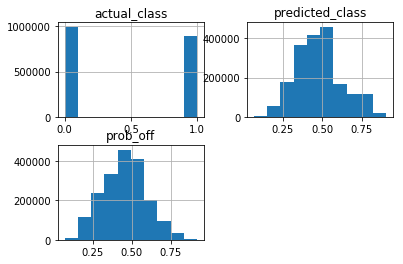

In [188]:
# Plot to see the distribution of the errors
model_preds.hist()

In [191]:
# Example of a well predicted comment of a non-fan
print('-------------------------')
print('----predicted as: {}'.format(model_preds.sort_values('prob_off')['predicted_class'][0]))
print('----actually: {}---(1 = fan, 0 = not fan --------'.format(model_preds.sort_values('prob_off')['actual_class'][0]))
print('-------comment-----------')
print(model_preds.sort_values('prob_off').index[0])

-------------------------
----predicted as: 0.06995964050292969
----actually: 0---(1 = fan, 0 = not fan --------
-------comment-----------
**Fencing response**

The fencing response is a peculiar position of the arms following a concussion. Immediately after moderate forces have been applied to the brainstem, the forearms are held flexed or extended (typically into the air) for a period lasting up to several seconds after the impact. The fencing response is often observed during athletic competition involving contact, such as American football, hockey, rugby and martial arts. It is used as an overt indicator of injury force magnitude and midbrain localization to aid in injury identification and classification for events including, but not limited to, on-field and/or bystander observations of sports-related head injuries.

***

^[ [^PM](https://www.reddit.com/message/compose?to=kittens_from_space) ^| [^Exclude ^me](https://reddit.com/message/compose?to=WikiTextBot&message=Excludeme&subj

In [206]:
# Example of a well predicted comment of a fan



print('-------------------------')
print('----predicted as: {}'.format(model_preds.loc[model_preds['actual_class'] == 1].sort_values('prob_off')['predicted_class'][2]))
print('----actually: {}---(1 = fan, 0 = not fan --------'.format(model_preds.loc[model_preds['actual_class'] == 1].sort_values('prob_off')['actual_class'][2]))
print('-------comment-----------')
print(model_preds.loc[model_preds['actual_class'] == 1].sort_values('prob_off').index[2])

-------------------------
----predicted as: 0.9008954763412476
----actually: 1---(1 = fan, 0 = not fan --------
-------comment-----------
Our only starting OL is our LT. Our ILB medically retired, we don't have our 1st, 2nd, 3rd, WR, our three starting RBs and our breakout CB last year in Tavon Young. Our other CB Hill who showed out in preseason is hurt. Our 2nd and 3rd TE are out. We have 20 on IR. 

We are 3-3, tied 6-6 with Sota and one game out of 1st in our division with 2 division wins. 


In [211]:
# Example of a poorly predicted comment of a non-fan
print('-------------------------')
print('----predicted as: {}'.format(model_preds.sort_values('prob_off')['predicted_class'][-1]))
print('----actually: {}---(1 = fan, 0 = not fan --------'.format(model_preds.sort_values('prob_off')['actual_class'][-1]))
print('-------comment-----------')
print(model_preds.sort_values('prob_off').index[-1])

-------------------------
----predicted as: 0.0809553861618042
----actually: 1---(1 = fan, 0 = not fan --------
-------comment-----------
What...what do you mean?  

Edit:  I'll attempt to answer.

> *How* is New England the 1 seed in the AFC?

New England is the 1 seed because they beat the Pittsburgh Steelers to take first seed, due to tiebreaker going to the Pats due to the win.  

> How is *New England* the 1 seed in the AFC?

They went 4-2 in their first 6 games of the season, arguably the hardest games on the schedule.  They finish off the season with mostly divisional matchups, for which they are currently 4-1 in.  

> How is New England the *1* seed in the AFC?

Tiebreaker over Pittsburgh.  

> How is New England the 1 seed in the *AFC*?

The Patriots play in the AFC.  


In [217]:
# Example of a poorly predicted comment of a fan
print('-------------------------')
print('----predicted as: {}'.format(model_preds.sort_values('prob_off')['predicted_class'][-10]))
print('----actually: {}---(1 = fan, 0 = not fan --------'.format(model_preds.sort_values('prob_off')['actual_class'][-10]))
print('-------comment-----------')
print(model_preds.sort_values('prob_off').index[-10])

-------------------------
----predicted as: 0.0934571623802185
----actually: 1---(1 = fan, 0 = not fan --------
-------comment-----------
In the lead-up to the eclipse, I read a lot about the damage you could do to your eyes by looking at it without the proper protective glasses on. They said optomotrists would be able to tell you looked at the sun, because the outline of the eclipse would be burned into the cornea. For the rest of your life, that image is literally burned into your eye. It never goes away. It never heals. The damage is permanent.

If you look into my eyes, you can see the outline of the David Tyree helmet catch. It never goes away. It never heals. The damage is permanent.

I wish you the best this season, my friend.


In [233]:
# Example of a poorly predicted comment of a non-fan
# They actually sound like a fan - probably mislabeled
print('-------------------------')
print('----predicted as: {}'.format(model_preds.sort_values('prob_off')['predicted_class'][-21]))
print('----actually: {}---(1 = fan, 0 = not fan --------'.format(model_preds.sort_values('prob_off')['actual_class'][-21]))
print('-------comment-----------')
print(model_preds.sort_values('prob_off').index[-21])

-------------------------
----predicted as: 0.8980789184570312
----actually: 0---(1 = fan, 0 = not fan --------
-------comment-----------
the biggest problem is injuries and in a close second our pass blocking. if we were healthy and our pass blocking was competent our pass heavy offense would work but eli has had 2 seconds to throw the ball and has made bad throws with players wide open. you can definitely say our defense has still been good regardless of the shit show our offense has been and that is without our best coverage LB and last game without our MLB and Jackrabbit.  


In [237]:
# Example of a poorly predicted comment of a non-fan
# They actually sound like a fan too! Probably mislabeled
print('-------------------------')
print('----predicted as: {}'.format(model_preds.sort_values('prob_off')['predicted_class'][-29]))
print('----actually: {}---(1 = fan, 0 = not fan --------'.format(model_preds.sort_values('prob_off')['actual_class'][-29]))
print('-------comment-----------')
print(model_preds.sort_values('prob_off').index[-29])

-------------------------
----predicted as: 0.8941841125488281
----actually: 0---(1 = fan, 0 = not fan --------
-------comment-----------
There defense has only allowed one team to score 20 points and in the 4th quarter the offense tends to get their head out of their asses. Our offense is 32nd in the league and the defense has the ability to be top 10. Our oline is killing us. Our LT is hurt and we are missing both of our starting guards. It's bad


# Use the model to predict some test cases

In [243]:
tests = ['we are awesome',
         'our team is awesome',
         'jags suck',
         'when will we win',
         'we are so dumb',
         'they suck',
         'why arent we winning',
        'this is hilarious',
        'just tuned in',
        'rigged refs',
        'i hate football',
        'i love football',
        'that was a horrible call',
        'we are so good',
        'they',
        'we',
        'tom brady is so good that they dont know what to do with him',
        'I love Lions fans cause we can drink bleach together this christmas eve']
encoded_test = [one_hot(str(d), vocab_size) for d in tests]
padded_test = pad_sequences(encoded_test, maxlen=max_length, padding='post')
preds_test = model.predict(padded_test)

In [244]:
test_results = pd.DataFrame(index=tests)
test_results['prediction'] = 0
test_results['prediction'] = preds_test
# Predicted class is actually the inverse (I think)
test_results['prediction'] = 1 - test_results['prediction']
test_results

,prediction
we are awesome,0.647458
our team is awesome,0.767350
jags suck,0.232012
when will we win,0.749833
we are so dumb,0.714126
they suck,0.451200
why arent we winning,0.752060
this is hilarious,0.378172
just tuned in,0.209693
rigged refs,0.468423
